# Question 2. IWAL algorithm implementation (50 points)

The purpose of this question is to implement Importance Weighted Active Learning (IWAL) algorithm. For this question, you will not use modAL, but instead will implement IWAL routine from scratch using scikit-learn, NumPy and native Python. In this question, we will use a simple synthetic dataset for a binary classification problem. Each data point has only 2 features. The dataset is provided in 2 files -- “data_iwal.npy”, which contains features and “labels_iwal.npy”, which contains labels. For simplicity, you will implement bootstrapping rejection sampling subroutine with logistic regression and hinge loss.   

𝐂𝐨𝐦𝐩𝐥𝐞𝐭𝐞 𝐭𝐡𝐞 𝐜𝐨𝐝𝐞 𝐮𝐧𝐝𝐞𝐫 \#\#\#𝐓𝐎 𝐃𝐎 𝐢𝐧 𝐞𝐚𝐜𝐡 𝐜𝐞𝐥𝐥 𝐚𝐧𝐝 𝐩𝐫𝐨𝐝𝐮𝐜𝐞 𝐭𝐡𝐞 𝐫𝐞𝐪𝐮𝐢𝐫𝐞𝐝 𝐩𝐥𝐨𝐭𝐬.  Feel free to define any helper functions as you see fit. You may import and use any modules in scikit-learn and NumPy to help with your implementations.

## Imports

Here we import necessary modules. Feel free to add something else here if you need it!

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import hinge_loss, log_loss
from sklearn.linear_model import LogisticRegression

## Reading data

Here we read the data and split it into train and test datasets. Train will be used to train our classification model and test will be used to validate the performance, monitor overfitting and compare the results of the model trained with Active Learning with the ones of the model trained from scratch. We set aside 1/3 of the dataset for validation.

In [2]:
X = np.load("data/q2/data_iwal.npy")
y = np.load("data/q2/labels_iwal.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Part 2.1
Type your answers for the theoretical questions below.

1. What is the idea behind IWAL algorithm?

The distribution of training data and testing data are not the same. If we can assign a weight to data point, 
$$w = \frac{P_{train}}{P_{test}}$$
Then we can produce a better model with lower generalization error.

2. What are the assumptions made for the IWAL algorithm?

Training data and testing data do not follow same distribution.

3. What are the pros and cons of IWAL algorithm?

Pros: it does not infer labels, so won't mislabel instances. It can be used with multiple data access models and loss functions. It can handle non-separable data and compensate for sampling bias using importance weighting. It guarantees to converge to the optimal model and bounds the number of needed samples.

Cons: weighting can not be computed directly. It has to use approximation algorithm.

## Part 2.2 Implement IWAL algorithm

In this part you will implement a functiom that performs a single query of Algorithm 1 IWAL (subroutine rejection-sampling) from the paper. Below is the function description that you can follow in your implementation.

In [4]:
### TODO: Implement Algorithm 1 from the paper
def IWAL_query(x_t, y_t, rejection_sampling, history, h, **kwargs):
    """
    This function implements a single query if IWAL algorithm from the paper 
    by Beygelzimer et al https://arxiv.org/pdf/0812.4952.pdf
    Args:
        x_t: currently considered sample 
        y_t: label for x, will be added to history if requested
        rejection_sampling: python function, that accepts current data point x_t and 
        some arbitrary arguments and returns probability of requesting a label for x_t
        history: dictionary of previous history. history.keys() will return dict_keys(['X', 'y', 'c', 'Q']), 
        where, X -- is a history of sampled data points, y -- labels for samples in X, c -- weights for 
        samples in X.
        h: scikit-learn model class, such as sklearn.linear_model.LogisticRegression, etc
        **kwargs: dictionary of arbitrary arguments that may be required by rejection_sampling()
    Returns: 
        h_t: object of scikit-learn model class h, that is optimal at current time step.
    """
    ### Your code goes here
    labels = [0,1]
    loss = 0.0
    p_t = bootstrap(x_t, kwargs['H'], kwargs['labels'], loss)
    Q_t = np.random.binomial(1, p_t, 1)[0]
    h_t = h
    sample = True
    if Q_t == 1:
        history['X'] = np.vstack((history['X'], x_t))
        history['y'] = np.hstack((history['y'], y_t))
        history['c'] = np.hstack((history['c'], np.array(1/p_t)))
        sample = True
        h_t.fit(history['X'], history['y'], sample_weight=history['c'])
    else:
        sample = False
    return h_t, sample

## Part 2.3 Implement bootstraing rejection sampling subroutine

In this part you will implement bootstrapping rejection sampling subroutine from the paper, section 7.2

In [5]:
def bootstrap(x, H, labels, loss, p_min=0.1):
    """
    This function implements bootstrap rejection sampling subroutine.
    Args:
        x: array-like object of features for currently considered sample
        H: list of hypothesis (scikit-learn objects) that are used in voting
        labels: list of possible labels for the problem. If binary classifiction, labels=[0, 1]
        p_min: minimum threshold for the probability
    Returns:
        p_t: probability of requesting the label for x, which is equal to:
            p_min + (1 - p_min)(max_{y, h_i, h_j} L(h_i(x), y) - L(h_j(x), y))
    """
    max_value = -10000
    for i in range(len(H)):
        for j in range(len(H)):
            for y in labels:
                i_pred = H[i].predict_proba(x)
                j_pred = H[j].predict_proba(x)
                tmp_value =  hinge_loss(np.array([y]), np.array([i_pred[0][y]]), labels=labels) - hinge_loss(np.array([y]), np.array([j_pred[0][y]]), labels=labels)
                if tmp_value > max_value:
                    max_value = tmp_value
                # TODO: calculate max_value = max_{y, h_i, h_j} L(h_i(x), y) - L(h_j(x), y)
    return p_min + (1 - p_min)*max_value

## Part 2.4 Organize all implemented parts into a single pipeline

Now you implemented all part of IWAL algorithm with bootstrap rejection sampling and can organize it into a pipeline

In [6]:
def bootstrap_samples(X_training, y_training):
    n = X_training.shape[0]
    idx = [None] * n
    for i in range(n):
        idx[i] = np.random.randint(0, n)
    return X_training[idx, :], y_training[idx]

In [7]:
history = {}
losses = []
n_initial = 10
n_h = 10

X_training, y_training = X_train[:n_initial], y_train[:n_initial]
#Initialization: initialize history and H
## TODO: your code here
history['X'] = X_training
history['y'] = y_training
history['c'] = np.ones(shape=(X_training.shape[0],))
H = []
# Create n_h classifiers and train them on bootstrapped data (data is sampled with replacement)
## TODO: your code goes here
for i in range(n_h):
    h = LogisticRegression()
    x, y = bootstrap_samples(X_training, y_training)
    h.fit(x, y)
    H.append(h)
    
# Perform queries and record loss
n_query = 50
h_t = LogisticRegression()
h_t.fit(X_training, y_training)
while n_query != 0:
    ### TODO: your code goes here
    idx = np.random.randint(0, X_train.shape[0])
    x_t = X_train[idx, :].reshape(1,-1)
    y_t = y_train[idx].reshape(1,)
    h_t, is_sample = IWAL_query(x_t, y_t, bootstrap, history, h_t, H=H, labels=[0,1])
    if is_sample:
        losses.append(log_loss(y_test, h_t.predict_proba(X_test)))
        n_query -= 1
        X_train,  y_train= np.delete(X_train, idx, axis=0), np.delete(y_train, idx, axis=0)

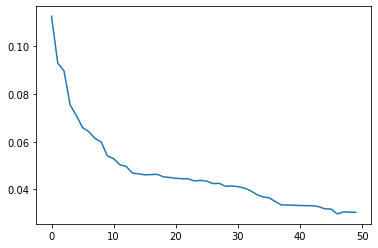

In [8]:
plt.plot(losses)

## Part 2.5 Compare results of Active Learning vs No Active Learning

In this part you need to create object of the same scikit learning class and train it on randomly selected subset of data points and compare results of 2 classifiers. Comment on your observations

In [9]:
# Compare to no Active Learning setting

## TODO: your code goes here

In [10]:
losses_n = []
n_initial = 10

X_training, y_training = X_train[:n_initial], y_train[:n_initial]

h_n = LogisticRegression()
h_n.fit(X_training, y_training)
n_query = 50
for t in range(n_query):
    ### TODO: your code goes here
    idx = np.random.randint(0, X_train.shape[0])
    x_t = X_train[idx, :].reshape(1,-1)
    y_t = y_train[idx].reshape(1,)
    X_training = np.vstack((X_training, x_t))
    y_training = np.hstack((y_training, y_t))
    h_n.fit(X_training, y_training)
    X_train,  y_train= np.delete(X_train, idx, axis=0), np.delete(y_train, idx, axis=0)
    losses_n.append(log_loss(y_test, h_n.predict_proba(X_test)))

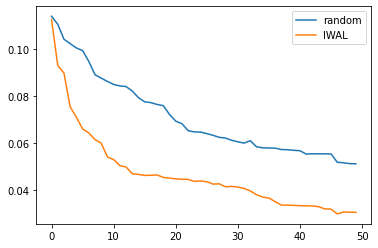

In [11]:
plt.plot(losses_n, label='random')
plt.plot(losses, label='IWAL')
plt.legend()